In [26]:
import pandas as pd
import nltk
from collections import Counter
import re
import Levenshtein as lev

from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)
stopwords = stopwords.words("english")
stopwords.extend(["br", "ect", "hou", "com", "enron", "cc", "http", "www", "corp", "forwarded", "ees"])
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk import pos_tag

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

In [2]:
# read in data

epa_data = pd.read_csv('../data/epa_data.csv')
pos_list = pd.read_csv('../data/POS List.csv')

In [3]:
epa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6734 entries, 0 to 6733
Data columns (total 10 columns):
EmailID                          6734 non-null object
Subject                          6516 non-null object
Message                          6734 non-null object
TaskSentence                     6734 non-null object
Judgements                       6734 non-null object
From.emailAddress.Name           6734 non-null object
From.emailAddress.ExternalId     0 non-null float64
From.emailAddress.Address        6734 non-null object
ToRecipients.emailAddressList    6734 non-null object
CcRecipients.emailAddressList    6734 non-null object
dtypes: float64(1), object(9)
memory usage: 526.2+ KB


In [4]:
epa_data.head(3)

,EmailID,Subject,Message,TaskSentence,Judgements,From.emailAddress.Name,From.emailAddress.ExternalId,From.emailAddress.Address,ToRecipients.emailAddressList,CcRecipients.emailAddressList
0,d7ZnSLcWHfdM9p97euzNkA==,Power DB Field Requirements,Chris - Attached is the spreadsheet shared wit...,Please forward back with any changes you might...,[{'1ed221006fdcbad8': ['chris.stokley@enron.co...,Fisher,NaN,steven.fisher@enron.com,"[{'emailAddress': {'Name': 'Stokley', 'Externa...",[]
1,l9qlLljWb7vV0Vz1P2/gWQ==,Re:,I agree with your proposal. <mark>Please comm...,Please communicate with Mark Holsworth.,[{'7dab55c4c50746f1': ['michelle.cash@enron.co...,Mark E Haedicke,NaN,mark.haedicke@enron.com,"[{'emailAddress': {'Name': 'Michelle Cash', 'E...",[]
2,L2HeC/lMpFK7xyVO7nxZsA==,Tony's deals,-Origin: LEWIS-A<br/>X-FileName: andy lewis 6-...,Andy - can you please forward this email to yo...,[{'7ba3b6a138bcadee': ['andrew.lewis@enron.com...,Richard Tomaski <Richard Tomaski/Corp/Enron@EN...,NaN,richard.tomaski@enron.com,"[{'emailAddress': {'Name': 'Andrew H Lewis', '...","[{'emailAddress': {'Name': 'Hunter S Shively',..."


In [20]:
# remove digits (https://stackoverflow.com/questions/43216530/adding-numbers-to-stop-words-to-scikit-learns-countvectorizer/45024512)
# remove <name> tags as well
# also removes __: __ those things as well (like "Origin: LEWIS- ")

def no_number_preprocessor(tokens):
    # This alternative just replaces numbers with NUM token:
    # r = re.sub('(\d)+', 'NUM', tokens.lower())
    r = re.sub("(\d)+", "", tokens.lower())
    r = re.sub("<.*?>", " ", r)
    return r

In [27]:
# tokenize text

def ngrams(target, n=2):
    corpus = epa_data[target]
    count_vec = CountVectorizer(analyzer="word", stop_words=stopwords, ngram_range=(n, n), preprocessor=no_number_preprocessor).fit(corpus)
    bag_of_words = count_vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [28]:
# plot 2 sns barplots side by side

def plot_bars(x1, y1, x2, y2, num_ngrams=30):
    fig, ax = plt.subplots(1,2, figsize=(20,8))
    sns.barplot(x=y1, y=x1, orient='h', palette="Reds_d", ax=ax[0])
    sns.barplot(x=y2, y=x2, orient='h', palette="Blues_d", ax=ax[1])

    ax[0].set_title("Top " + str(num_ngrams) + " Task Words")
    ax[0].set_xlabel("Keyword Frequency")
    ax[1].set_title("Top " + str(num_ngrams) + " Email Words")
    ax[1].set_xlabel("Keyword Frequency")
    plt.tight_layout()
    plt.show()

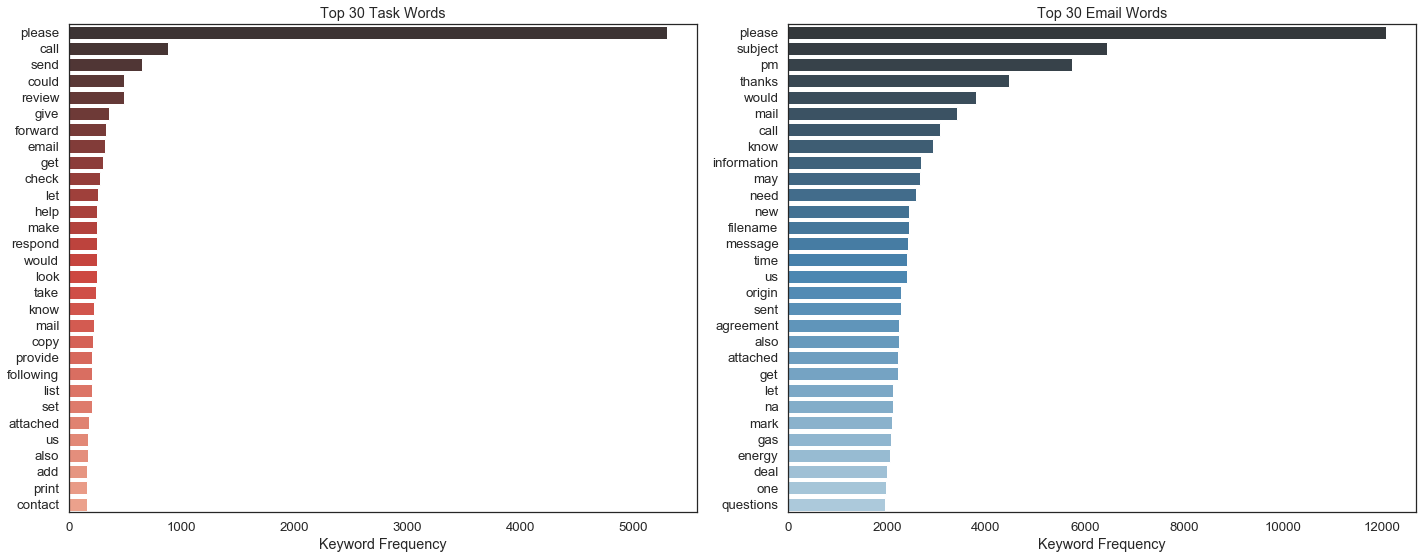

In [29]:
# word frequency

task_words = ngrams("TaskSentence", 1)[:30]
message_words = ngrams("Message", 1)[:30]

x_task, y_task = map(list, zip(*task_words))
x_message, y_message = map(list, zip(*message_words))

plot_bars(x_task, y_task, x_message, y_message)

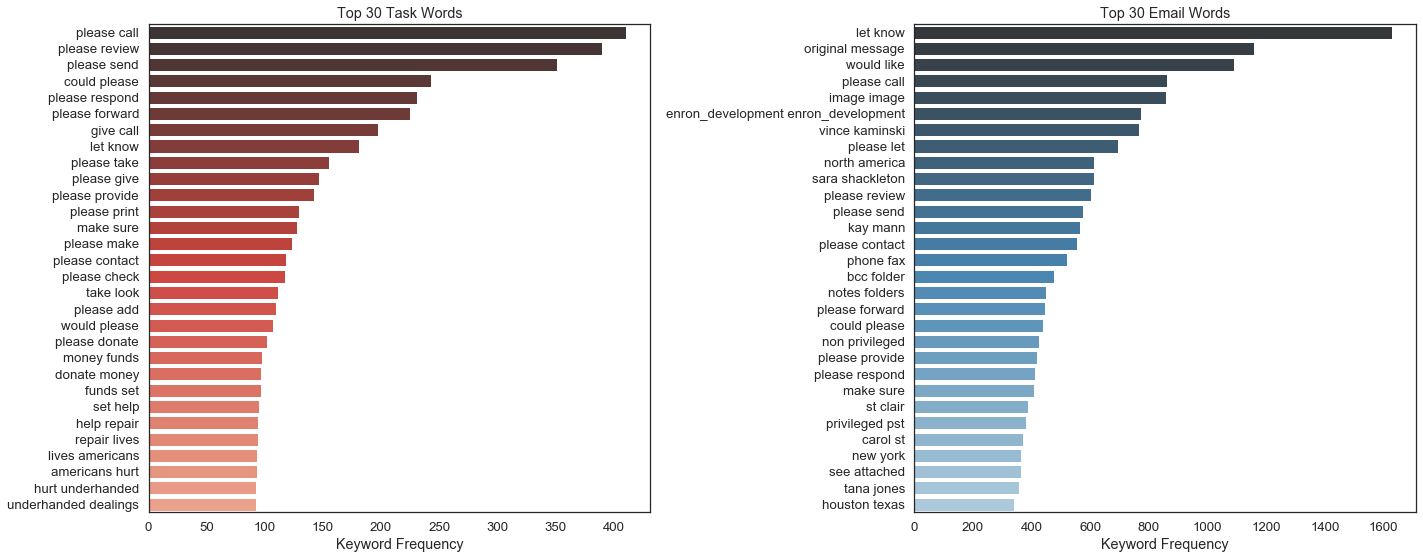

In [30]:
# bigram frequency

task_words_bigrams = ngrams("TaskSentence", 2)[:30]
message_words_bigrams = ngrams("Message", 2)[:30]

x_task_2, y_task_2 = map(list, zip(*task_words_bigrams))
x_message_2, y_message_2 = map(list, zip(*message_words_bigrams))

plot_bars(x_task_2, y_task_2, x_message_2, y_message_2)

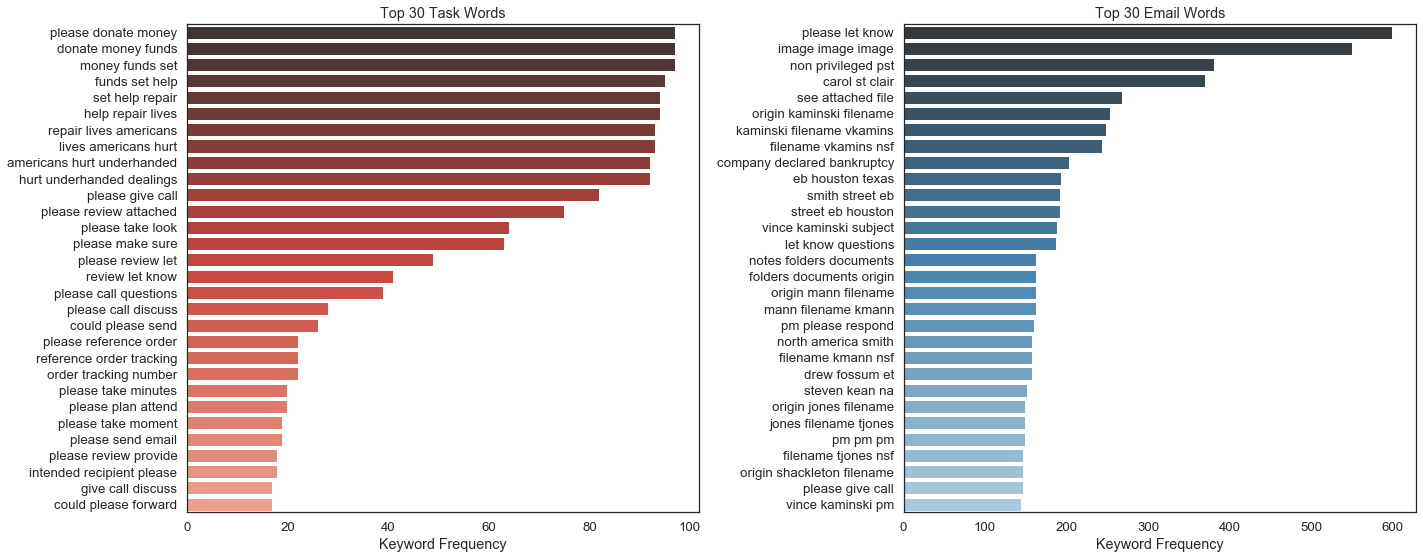

In [31]:
# trigram frequency

task_words_trigrams = ngrams("TaskSentence", 3)[:30]
message_words_trigrams = ngrams("Message", 3)[:30]

x_task_3, y_task_3 = map(list, zip(*task_words_trigrams))
x_message_3, y_message_3 = map(list, zip(*message_words_trigrams))

plot_bars(x_task_3, y_task_3, x_message_3, y_message_3)

In [32]:
# find total counts for words in Message and TaskSentence

message_counts = ngrams("Message", 1)
message_dict = dict(message_counts)
total_messages = sum(message_dict.values())

task_counts = ngrams("TaskSentence", 1)
task_dict = dict(task_counts)
total_tasks = sum(task_dict.values())

In [33]:
# frequency a word is from task or message

def find_probs(word):
    message_prob = message_dict[word]/total_messages
    try:
        task_prob = task_dict[word]/total_tasks
    except:
        task_prob = 0
    return [word, message_prob, task_prob]

# make df of probabilities

probs = [find_probs(w) for w in message_dict.keys()]
prob_df = pd.DataFrame(data=probs, columns=["word", "frequency in message", "frequency in task"])

In [34]:
# sorted by frequency in message

prob_df.sort_values(["frequency in message"], ascending=False)[0:10]

,word,frequency in message,frequency in task
0,please,0.014057,0.142680
1,subject,0.007488,0.000404
2,pm,0.006675,0.000512
3,thanks,0.005187,0.000996
4,would,0.004411,0.006625
5,mail,0.003977,0.005979
6,call,0.003559,0.023592
7,know,0.003402,0.006086
8,information,0.003134,0.002882
9,may,0.003101,0.001239


In [35]:
# sorted by likeliness in task

prob_df.sort_values(["frequency in task"], ascending=False)[0:10]

,word,frequency in message,frequency in task
0,please,0.014057,0.142680
6,call,0.003559,0.023592
31,send,0.002241,0.017478
37,could,0.002023,0.013250
40,review,0.001987,0.013142
89,give,0.001161,0.009668
48,forward,0.001697,0.008860
32,email,0.002225,0.008537
21,get,0.002587,0.008241
116,check,0.000993,0.007514


In [36]:
# preprocess messages

message_corpus = [sent_tokenize(no_number_preprocessor(m)) for m in epa_data["Message"]]
task_corpus = [no_number_preprocessor(t) for t in epa_data["TaskSentence"]]

In [37]:
# find placement of the task sentence in the message using fuzzy matching

sentence_order = []
num_sentences = []

for message, task in zip(epa_data["Message"], epa_data["TaskSentence"]):
    message_corpus = sent_tokenize(no_number_preprocessor(message))
    task = no_number_preprocessor(task)
    
    fuzzy_matching_sentences = [lev.ratio(sentence, task) for sentence in message_corpus]
#     print(max(fuzzy_matching_sentences))
    
    sentence_order.append(max(range(len(fuzzy_matching_sentences)), key=fuzzy_matching_sentences.__getitem__))
    num_sentences.append(len(fuzzy_matching_sentences))

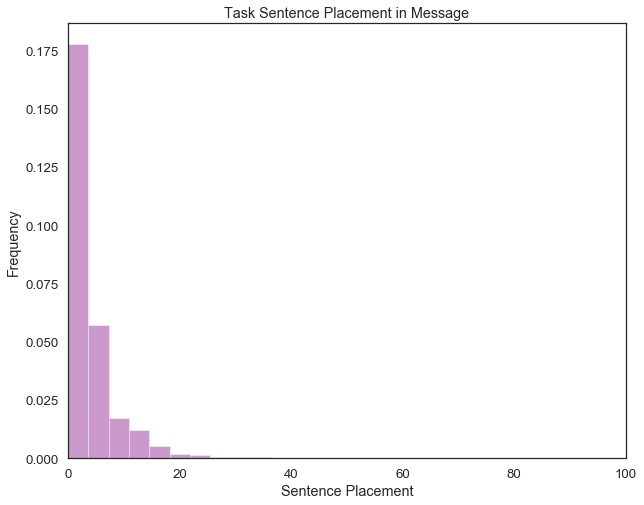

In [48]:
# plot task sentence placements
plt.xlim(0, 100)
sns.distplot(sentence_order, kde=False, norm_hist=True, color="purple", bins=100)
plt.title("Task Sentence Placement in Message")
plt.xlabel("Sentence Placement")
plt.ylabel("Frequency");

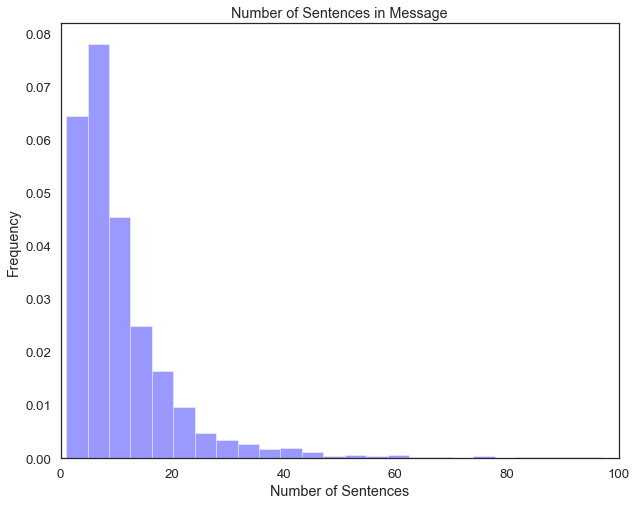

In [49]:
# number of sentences in message

plt.xlim(0, 100)
sns.distplot(num_sentences, kde=False, norm_hist=True, color="blue", bins=100)
plt.title("Number of Sentences in Message")
plt.xlabel("Number of Sentences")
plt.ylabel("Frequency");

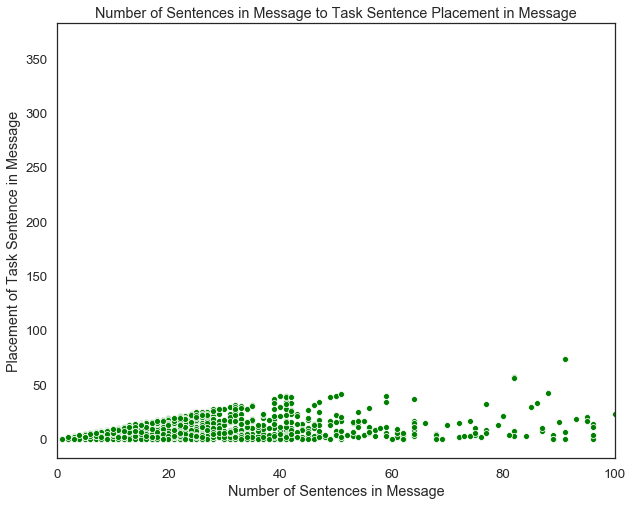

In [46]:
# number of sentences in messages to task sentence placement in message

plt.xlim(0, 100)
sns.scatterplot(x=num_sentences, y=sentence_order, color="green")
plt.title("Number of Sentences in Message to Task Sentence Placement in Message")
plt.xlabel("Number of Sentences in Message")
plt.ylabel("Placement of Task Sentence in Message");

In [50]:
# create part of speech dict

pos_dict = {}

for pos in range(len(pos_list)):
    pieces = pos_list["POS tag list:"][pos].split(" ", 1)
    pos_dict[pieces[0]] = pieces[1]
    
pos_dict[":"] = "grammar"
pos_dict["."] = "grammar"
pos_dict[","] = "grammar"

In [51]:
# this is like the slowest way ever to do this smh
# part of speech tagging messages and tasks

message_pos = []
task_pos = []

for i in range(len(epa_data)):
    if i%1000 == 0:
        print(i)
    m = epa_data["Message"][i]
    t = epa_data["TaskSentence"][i]
    message_pos.extend(dict(pos_tag(word_tokenize(no_number_preprocessor(m)))).values())
    task_pos.extend(dict(pos_tag(word_tokenize(no_number_preprocessor(t)))).values())

0
1000
2000
3000
4000
5000
6000


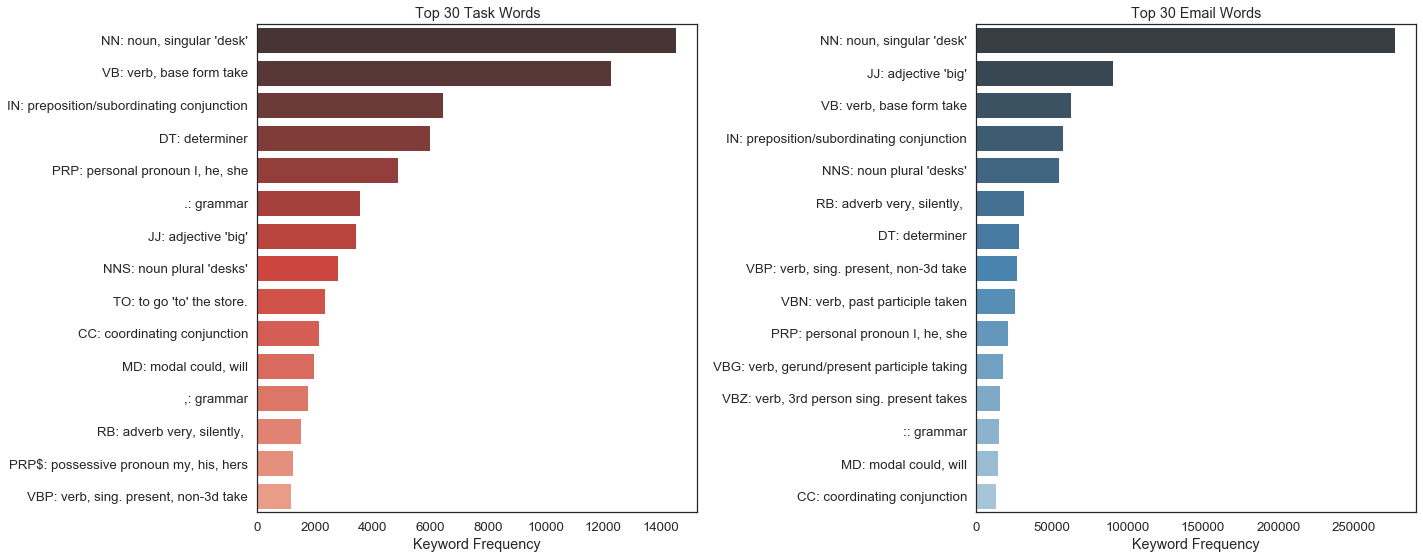

In [76]:
# plot part of speech frequencies

mp = Counter(message_pos).most_common(15)
tp = Counter(task_pos).most_common(15)

x_task, y_task = map(list, zip(*tp))
x_message, y_message = map(list, zip(*mp))

x_task = [xp + ": " + pos_dict[xp] for xp in x_task]
x_message = [xp + ": " + pos_dict[xp] for xp in x_message]

plot_bars(x_task, y_task, x_message, y_message)